# Mislabeled data detection - RoBERTa-MRPC

This notebook demonstrates how to efficiently compute the influence functions using DataInf, showing its application to **mislabeled data detection** tasks.

- Model: Robert-large (https://arxiv.org/abs/1907.11692; pretrained with BOOKCORPUS, WIKIPEDIA, CC-NEWS, to name a few)
- Fine-tuning dataset: GLUE-mrpc
    - What is MRPC? The Microsoft Research Paraphrase Corpus (Dolan & Brockett, 2005) is a corpus of sentence pairs automatically extracted from online news sources, with human annotations for whether the sentences in the pair are semantically equivalent.

References
- https://github.com/huggingface/peft/blob/main/examples/sequence_classification/LoRA.ipynb
- DataInf is available at this [ArXiv link](https://arxiv.org/abs/2310.00902).

In [2]:
import sys
sys.path.append('../src')
from dataloader import create_dataloaders, load_noisy_dataset_by_task
from lora_model import LORAEngine
from influence import IFEngine

import numpy as np
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
import os

## Set up hyperparameters and LoRA models

In [95]:
model_name_or_path="roberta-large"
task="mrpc"
noise_ratio=0.2
batch_size=32
target_modules=["value"]
device="cuda:4"
num_epochs=10
lr=3e-4

In [96]:
mrpc_02_noise, noise_added=load_noisy_dataset_by_task(task="mrpc", noise_ratio=0.2)

In [97]:
mrpc_02_noise

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

In [98]:
# task_to_keys = {
#     "cola": ("sentence", None),
#     "mrpc": ("sentence1", "sentence2"),
#     "qnli": ("question", "sentence"),
#     "qqp": ("question1", "question2"),
#     "rte": ("sentence1", "sentence2"),
#     "sst2": ("sentence", None),
#     "wnli": ("sentence1", "sentence2"),
# }

# tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, padding_side="right")
# tokenizer.pad_token = tokenizer.eos_token
# tokenizer.pad_token_id = tokenizer.eos_token_id

# sentence1_key, sentence2_key = task_to_keys[task]
# def tokenize_function(examples, max_length=128):
#     # max_length=None => use the model max length (it's actually the default)
#     if sentence2_key is None:
#         outputs = tokenizer(examples[sentence1_key], truncation=True, max_length=max_length)
#     else:
#         outputs = tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True, max_length=max_length)
#     return outputs

# if sentence2_key is None:
#         tokenized_datasets = noisy_datasets.map(
#             tokenize_function,
#             batched=True, 
#             remove_columns=["idx", sentence1_key],
#         )
# else:
#     tokenized_datasets = noisy_datasets.map(
#         tokenize_function,
#         batched=True,
#         remove_columns=["idx", sentence1_key, sentence2_key],
#     )

# # We also rename the 'label' column to 'labels' which is the expected name for labels by the models of the
# # transformers library
# tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# def collate_fn(examples):
#     return tokenizer.pad(examples, padding="longest", return_tensors="pt")  


# train_dataloader = DataLoader(tokenized_datasets["train"],
#                                 shuffle=False, 
#                                 collate_fn=collate_fn,
#                                 batch_size=batch_size)
# eval_dataloader = DataLoader(tokenized_datasets["validation"], 
#                                 shuffle=False, 
#                                 collate_fn=collate_fn, 
#                                 batch_size=batch_size)

In [99]:
# dataloader_outputs = create_dataloaders(model_name_or_path=model_name_or_path,
#                                            task=task,
#                                            noise_ratio=noise_ratio,
#                                            batch_size=batch_size)
# check_train_dataloader, check_eval_dataloader, check_noise_index, check_tokenized_datasets, check_collate_fn = dataloader_outputs

In [100]:
# fine-tuning models
dataloader_outputs = create_dataloaders(model_name_or_path=model_name_or_path,
                                           task=task,
                                           noise_ratio=noise_ratio,
                                           batch_size=batch_size)
train_dataloader, eval_dataloader, noise_index, tokenized_datasets, collate_fn = dataloader_outputs



lora_engine = LORAEngine(model_name_or_path=model_name_or_path,
                            target_modules=target_modules,
                            train_dataloader=train_dataloader,
                            eval_dataloader=eval_dataloader,
                            device=device,
                            num_epochs=num_epochs,
                            lr=lr,
                            low_rank=8, 
                            task=task)

/home/haskari/miniconda3/envs/influence/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Fine-tune a model

In [101]:
!nvidia-smi

Mon Jan 27 13:20:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    Off |   00000000:03:00.0 Off |                  Off |
| 30%   33C    P8             23W /  300W |   25483MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [102]:
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6,7"
lora_engine.build_LORA_model()
lora_engine.train_LORA_model()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,444,866 || all params: 356,806,660 || trainable%: 0.4049


100%|██████████| 13/13 [00:00<00:00, 14.94it/s]


Epoch 1: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:01<00:00, 12.67it/s]


Epoch 2: {'accuracy': 0.7132352941176471, 'f1': 0.8006814310051107}


100%|██████████| 13/13 [00:01<00:00, 12.52it/s]


Epoch 3: {'accuracy': 0.7647058823529411, 'f1': 0.8367346938775511}


100%|██████████| 13/13 [00:01<00:00, 12.64it/s]


Epoch 4: {'accuracy': 0.7892156862745098, 'f1': 0.8603896103896104}


100%|██████████| 13/13 [00:01<00:00, 12.44it/s]


Epoch 5: {'accuracy': 0.8186274509803921, 'f1': 0.8715277777777778}


100%|██████████| 13/13 [00:01<00:00, 12.39it/s]


Epoch 6: {'accuracy': 0.803921568627451, 'f1': 0.8662207357859532}


100%|██████████| 13/13 [00:01<00:00, 12.18it/s]


Epoch 7: {'accuracy': 0.8088235294117647, 'f1': 0.8729641693811075}


100%|██████████| 13/13 [00:01<00:00, 12.24it/s]


Epoch 8: {'accuracy': 0.8333333333333334, 'f1': 0.8866666666666667}


100%|██████████| 13/13 [00:01<00:00, 12.28it/s]


Epoch 9: {'accuracy': 0.8137254901960784, 'f1': 0.8741721854304636}


100%|██████████| 13/13 [00:01<00:00, 12.25it/s]

Epoch 10: {'accuracy': 0.8504901960784313, 'f1': 0.8953687821612349}


## Compute the gradient
 - Influence function uses the first-order gradient of a loss function. Here we compute gradients using `compute_gradient`
 - `tr_grad_dict` has a nested structure of two Python dictionaries. The outer dictionary has `{an index of the training data: a dictionary of gradients}` and the inner dictionary has `{layer name: gradients}`. The `val_grad_dict` has the same structure but for the validationd data points. 

In [103]:
tr_grad_dict, val_grad_dict = lora_engine.compute_gradient(tokenized_datasets, collate_fn)

100%|██████████| 408/408 [00:29<00:00, 13.69it/s]


## Compute the influence function
 - We compute the inverse Hessian vector product first using `compute_hvps()`. With the argument `compute_accurate=True`, the exact influence function value will be computed. (it may take an hour to compute).

In [104]:
influence_engine = IFEngine()
influence_engine.preprocess_gradients(tr_grad_dict, val_grad_dict, noise_index)
influence_engine.compute_hvps(compute_accurate=False)
influence_engine.compute_IF()

## Attributes of influence_engine
There are a couple of useful attributes in `influence_engine`. For intance, to compare the runtime, one case use `time_dict`.

In [105]:
influence_engine.time_dict

defaultdict(list,
            {'identity': 1.3113021850585938e-05,
             'proposed': 15.92891550064087,
             'LiSSA': 102.88751459121704})

`IF_dict` includes all the computed influence function values. Here, `identity` indicates the `Hessian-free` influence computation method. 

In [106]:
influence_engine.IF_dict.keys()

dict_keys(['identity', 'proposed', 'LiSSA'])

## Application to mislabeled data detection task
- We compare the mislabeled data detection ability of different influence computation methods. Given that large influence function values are likely to increase the validation loss, data points with large influence fucntion values are desired to be mislabeled. 
- We inspect data points from the largest to lowest influence function values and evaluate the detection rate. 

In [107]:
n_train=influence_engine.n_train
true_label=np.zeros(n_train)
true_label[noise_index]=1

method_dict={'identity': 'Hessian-free',
            'proposed': 'DataInf',
            'LiSSA': 'LiSSA'}

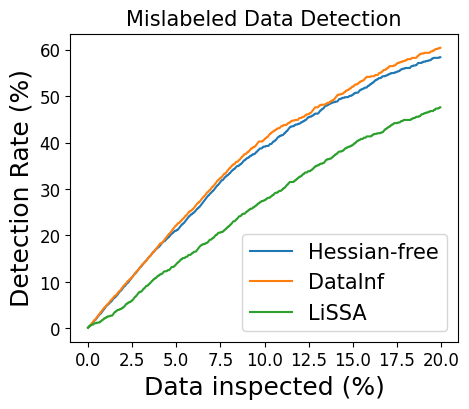

In [108]:
plt.figure(figsize=(5,4))
for method in influence_engine.IF_dict:
    detection_rate_list=[]
    low_quality_to_high_quality=np.argsort(influence_engine.IF_dict[method])[::-1]
    for ind in range(1, len(noise_index)+1):
        detected_samples = set(low_quality_to_high_quality[:ind]).intersection(noise_index)
        detection_rate = 100*len(detected_samples)/len(noise_index)
        detection_rate_list.append(detection_rate)
    plt.plot(100*np.arange(len(noise_index))/n_train, 
             detection_rate_list,
             label=method_dict[method])
plt.xlabel('Data inspected (%)', fontsize=18)
plt.ylabel('Detection Rate (%)', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)
plt.title('Mislabeled Data Detection', fontsize=15)
plt.show()

In [109]:
for method in influence_engine.IF_dict:
    low_quality_to_high_quality=np.argsort(influence_engine.IF_dict[method])[::-1]
    print(method)
    print(low_quality_to_high_quality[0:30])

identity
[ 178 2611  679 3044  548  986  246 2957 2644  134  903  192 1234    0
  217 2030  298 3299 2098 1681 2656 1106 2293 1586 2096 3066 2583 3145
 1284  874]
proposed
[ 178 2611  548 2644  298  903  246 2957  192 3066 1106 3299 2656 1725
 2583 2293 3145  414  134 1235  289 2098 2148 1284    0 2428 2353 1234
 2784 1057]
LiSSA
[ 178  679 2973 2611 1586  817  714 1619 1592  986 2002  259 3044  874
  747 2432 3448 1085 2071 1653 2877 1799 3665 2574  655 1286 1151 1813
 1047 1234]


In [113]:
datainf=np.argsort(influence_engine.IF_dict['proposed'])[::-1][0:100]
print(len(datainf))
count=0
for items in datainf:
    if items in noise_added:
        count+=1
print(count)

100
88


In [17]:
vals=np.argsort(influence_engine.IF_dict['identity'])[::-1]
identity_skip_set=vals[0:1350]
vals=np.argsort(influence_engine.IF_dict['proposed'])[::-1]
proposed_skip_set=vals[0:1350]
vals=np.argsort(influence_engine.IF_dict['LiSSA'])[::-1]
lissa_skip_set=vals[0:1350]

In [18]:
lissa_skip_set

array([2108, 1656,  473, ..., 3979, 3992, 4455])

In [19]:
valid_identity_indices = [i for i in range(4500) if i not in identity_skip_set]
valid_proposed_indices = [i for i in range(4500) if i not in proposed_skip_set]
valid_lissa_indices = [i for i in range(4500) if i not in lissa_skip_set]

In [21]:
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, LlamaTokenizer
from torch.utils.data import DataLoader
from datasets import DatasetDict

In [22]:
mrpc_02_noise_identity=DatasetDict()
mrpc_02_noise_proposed=DatasetDict()
mrpc_02_noise_lissa=DatasetDict()

In [23]:
mrpc_02_noise_identity['train']=mrpc_02_noise['train'].select(valid_identity_indices)
mrpc_02_noise_proposed['train']=mrpc_02_noise['train'].select(valid_proposed_indices)
mrpc_02_noise_lissa['train']=mrpc_02_noise['train'].select(valid_lissa_indices)

In [24]:
task_to_keys = {
    "cola": ("sentence", None),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "wnli": ("sentence1", "sentence2"),
}

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, padding_side="right")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

sentence1_key, sentence2_key = task_to_keys[task]
def tokenize_function(examples, max_length=128):
    # max_length=None => use the model max length (it's actually the default)
    if sentence2_key is None:
        outputs = tokenizer(examples[sentence1_key], truncation=True, max_length=max_length)
    else:
        outputs = tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True, max_length=max_length)
    return outputs

if sentence2_key is None:
        tokenized_datasets = mrpc_02_noise_identity.map(
            tokenize_function,
            batched=True, 
            remove_columns=["idx", sentence1_key],
        )
else:
    tokenized_datasets = mrpc_02_noise_identity.map(
        tokenize_function,
        batched=True,
        remove_columns=["idx", sentence1_key, sentence2_key],
    )

# We also rename the 'label' column to 'labels' which is the expected name for labels by the models of the
# transformers library
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

def collate_fn(examples):
    return tokenizer.pad(examples, padding="longest", return_tensors="pt")  


train_dataloader_identity = DataLoader(tokenized_datasets["train"],
                                shuffle=False, 
                                collate_fn=collate_fn,
                                batch_size=batch_size)


/home/haskari/miniconda3/envs/influence/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/3150 [00:00<?, ? examples/s]

In [25]:
task_to_keys = {
    "cola": ("sentence", None),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "wnli": ("sentence1", "sentence2"),
}

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, padding_side="right")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

sentence1_key, sentence2_key = task_to_keys[task]
def tokenize_function(examples, max_length=128):
    # max_length=None => use the model max length (it's actually the default)
    if sentence2_key is None:
        outputs = tokenizer(examples[sentence1_key], truncation=True, max_length=max_length)
    else:
        outputs = tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True, max_length=max_length)
    return outputs

if sentence2_key is None:
        tokenized_datasets = mrpc_02_noise_proposed.map(
            tokenize_function,
            batched=True, 
            remove_columns=["idx", sentence1_key],
        )
else:
    tokenized_datasets = mrpc_02_noise_proposed.map(
        tokenize_function,
        batched=True,
        remove_columns=["idx", sentence1_key, sentence2_key],
    )

# We also rename the 'label' column to 'labels' which is the expected name for labels by the models of the
# transformers library
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

def collate_fn(examples):
    return tokenizer.pad(examples, padding="longest", return_tensors="pt")  


train_dataloader_proposed = DataLoader(tokenized_datasets["train"],
                                shuffle=False, 
                                collate_fn=collate_fn,
                                batch_size=batch_size)


Map:   0%|          | 0/3150 [00:00<?, ? examples/s]

In [26]:
task_to_keys = {
    "cola": ("sentence", None),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "wnli": ("sentence1", "sentence2"),
}

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, padding_side="right")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

sentence1_key, sentence2_key = task_to_keys[task]
def tokenize_function(examples, max_length=128):
    # max_length=None => use the model max length (it's actually the default)
    if sentence2_key is None:
        outputs = tokenizer(examples[sentence1_key], truncation=True, max_length=max_length)
    else:
        outputs = tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True, max_length=max_length)
    return outputs

if sentence2_key is None:
        tokenized_datasets = mrpc_02_noise_lissa.map(
            tokenize_function,
            batched=True, 
            remove_columns=["idx", sentence1_key],
        )
else:
    tokenized_datasets = mrpc_02_noise_lissa.map(
        tokenize_function,
        batched=True,
        remove_columns=["idx", sentence1_key, sentence2_key],
    )

# We also rename the 'label' column to 'labels' which is the expected name for labels by the models of the
# transformers library
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

def collate_fn(examples):
    return tokenizer.pad(examples, padding="longest", return_tensors="pt")  


train_dataloader_lissa = DataLoader(tokenized_datasets["train"],
                                shuffle=False, 
                                collate_fn=collate_fn,
                                batch_size=batch_size)


Map:   0%|          | 0/3150 [00:00<?, ? examples/s]

In [27]:
lora_engine = LORAEngine(model_name_or_path=model_name_or_path,
                            target_modules=target_modules,
                            train_dataloader=train_dataloader_lissa,
                            eval_dataloader=eval_dataloader,
                            device=device,
                            num_epochs=num_epochs,
                            lr=lr,
                            low_rank=8, 
                            task=task)

In [28]:
lora_engine.build_LORA_model()
lora_engine.train_LORA_model()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,444,866 || all params: 356,806,660 || trainable%: 0.4049


100%|██████████| 16/16 [00:01<00:00, 11.31it/s]


Epoch 1: {'accuracy': 0.486}


100%|██████████| 16/16 [00:01<00:00, 11.17it/s]


Epoch 2: {'accuracy': 0.786}


100%|██████████| 16/16 [00:01<00:00, 10.98it/s]


Epoch 3: {'accuracy': 0.704}


100%|██████████| 16/16 [00:01<00:00, 10.91it/s]


Epoch 4: {'accuracy': 0.7}


100%|██████████| 16/16 [00:01<00:00, 10.85it/s]


Epoch 5: {'accuracy': 0.7}


100%|██████████| 16/16 [00:01<00:00, 10.79it/s]


Epoch 6: {'accuracy': 0.74}


100%|██████████| 16/16 [00:01<00:00, 10.72it/s]


Epoch 7: {'accuracy': 0.76}


100%|██████████| 16/16 [00:01<00:00, 10.72it/s]


Epoch 8: {'accuracy': 0.76}


100%|██████████| 16/16 [00:01<00:00, 10.64it/s]


Epoch 9: {'accuracy': 0.76}


100%|██████████| 16/16 [00:01<00:00, 10.64it/s]

Epoch 10: {'accuracy': 0.76}


In [29]:
lora_engine = LORAEngine(model_name_or_path=model_name_or_path,
                            target_modules=target_modules,
                            train_dataloader=train_dataloader_proposed,
                            eval_dataloader=eval_dataloader,
                            device=device,
                            num_epochs=num_epochs,
                            lr=lr,
                            low_rank=8, 
                            task=task)

In [30]:
lora_engine.build_LORA_model()
lora_engine.train_LORA_model()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,444,866 || all params: 356,806,660 || trainable%: 0.4049


 42%|████▏     | 42/99 [00:06<00:09,  6.26it/s]

In [ ]:
lora_engine = LORAEngine(model_name_or_path=model_name_or_path,
                            target_modules=target_modules,
                            train_dataloader=train_dataloader_identity,
                            eval_dataloader=eval_dataloader,
                            device=device,
                            num_epochs=num_epochs,
                            lr=lr,
                            low_rank=8, 
                            task=task)

In [ ]:
lora_engine.build_LORA_model()
lora_engine.train_LORA_model()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,444,866 || all params: 356,806,660 || trainable%: 0.4049


100%|██████████| 16/16 [00:01<00:00, 10.63it/s]


Epoch 1: {'accuracy': 0.514}


100%|██████████| 16/16 [00:01<00:00, 10.59it/s]


Epoch 2: {'accuracy': 0.598}


100%|██████████| 16/16 [00:01<00:00, 10.57it/s]


Epoch 3: {'accuracy': 0.846}


100%|██████████| 16/16 [00:01<00:00, 10.57it/s]


Epoch 4: {'accuracy': 0.856}


100%|██████████| 16/16 [00:01<00:00, 10.60it/s]


Epoch 5: {'accuracy': 0.858}


100%|██████████| 16/16 [00:01<00:00, 10.58it/s]


Epoch 6: {'accuracy': 0.834}


100%|██████████| 16/16 [00:01<00:00, 10.54it/s]


Epoch 7: {'accuracy': 0.86}


100%|██████████| 16/16 [00:01<00:00, 10.57it/s]


Epoch 8: {'accuracy': 0.824}


100%|██████████| 16/16 [00:01<00:00, 10.54it/s]


Epoch 9: {'accuracy': 0.842}


100%|██████████| 16/16 [00:01<00:00, 10.57it/s]

Epoch 10: {'accuracy': 0.824}
